In [1]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
PATH = '/content/drive/MyDrive/Parallel_PDE_project/fourier_neural_operator'
os.chdir(PATH)
import sys  
sys.path.insert(0, '/content/drive/MyDrive/Parallel_PDE_project/fourier_neural_operator/Notebooks')

In [3]:
from utils import *
from Adam import * 
# from FNO import *

In [4]:
################################################################
# load data and data normalization
################################################################
Darcy_flow_dir =  os.path.join(PATH, 'data', 'DarcyFlow')
x_train = torch.load( os.path.join(Darcy_flow_dir, 'darcy_flow_x_train.pt'))
y_train = torch.load(os.path.join(Darcy_flow_dir, 'darcy_flow_y_train.pt'))
x_test = torch.load(os.path.join(Darcy_flow_dir, 'darcy_flow_x_test.pt'))
y_test= torch.load(os.path.join(Darcy_flow_dir, 'darcy_flow_y_test.pt'))

In [5]:
#Parameters
ntrain = x_train.shape[0]
ntest = x_test.shape[0]
s = x_test.shape[-1]
batch_size = 20

In [6]:
x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)

x_train = x_train.reshape(ntrain,s,s,1)
x_test = x_test.reshape(ntest,s,s,1)

In [7]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [8]:
loss_train = []
loss_test =  []
epoch_vec = []

In [9]:
#NN parameters
activ_vec = ['relu', 'tanh', 'sine', 'gelu']
activ = activ_vec[0]
layers = 5
learning_rate = 0.005

epochs = 100
step_size = epochs//5
gamma = 0.5

wavenumber = 12
feature = 32

In [10]:
NotebooksPATH = '/content/drive/MyDrive/Parallel_PDE_project/fourier_neural_operator/Notebooks'
os.chdir(NotebooksPATH)
%run FNO.ipynb
model= FNO2d(features_= feature, wavenumber1= wavenumber, wavenumber2=wavenumber, layers = layers, activation= activ).to(device)
model

FNO2d(
  (lifting): Lifting(
    (fc1): Linear(in_features=3, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=32, bias=True)
  )
  (proj): Proj(
    (fc1): Linear(in_features=32, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=1, bias=True)
  )
  (fno): Sequential(
    (0): relu(FourierConv2d(32, 32, wavenumber=(12, 12)) + Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1)))
    (1): relu(FourierConv2d(32, 32, wavenumber=(12, 12)) + Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1)))
    (2): relu(FourierConv2d(32, 32, wavenumber=(12, 12)) + Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1)))
    (3): relu(FourierConv2d(32, 32, wavenumber=(12, 12)) + Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1)))
    (4): relu(FourierConv2d(32, 32, wavenumber=(12, 12)) + Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1)))
  )
)

In [11]:
print(count_params(model))

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(train_loader), epochs=epochs)
#scheduler= torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
myloss = LpLoss(size_average=False)
y_normalizer.to(device)

################################################################
# training and evaluation
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x).reshape(batch_size, s, s)
        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)

        loss = myloss(out.view(batch_size,-1), y.view(batch_size,-1))
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()
    
    epoch_vec.append(ep)
    #e= epoch_vec[-1]
    #epoch_vec.append(e+1)
    
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
    
            out = model(x).reshape(batch_size, s, s)
            out = y_normalizer.decode(out)

            test_l2 += myloss(out.view(batch_size,-1), y.view(batch_size,-1)).item()

    train_l2/= ntrain
    test_l2 /= ntest

    loss_train.append(train_l2)
    loss_test.append(test_l2)

    t2 = default_timer()
    print(ep, t2-t1, train_l2, test_l2)

2959361
0 2.772200870999768 0.24730714225769043 0.24908987045288086
1 2.6876177799999823 0.23001750087738038 0.20640626668930054
2 2.69057973200006 0.14973583281040193 0.11852531909942626


KeyboardInterrupt: ignored

In [ ]:
filename = f'FNO2D_epoch_{epochs}_wavenumber_{wavenumber}_features_{feature}_activ_{activ}_layers_{layers}'
filename

'FNO2D_epoch_100_wavenumber_12_features_32_activ_relu_layers_5'

In [ ]:
print(f'saving model at epoch {ep}')
file_path = os.path.join(PATH, 'trained_models')
torch.save(model, os.path.join(file_path, filename+'.plt'))

saving model at epoch 99


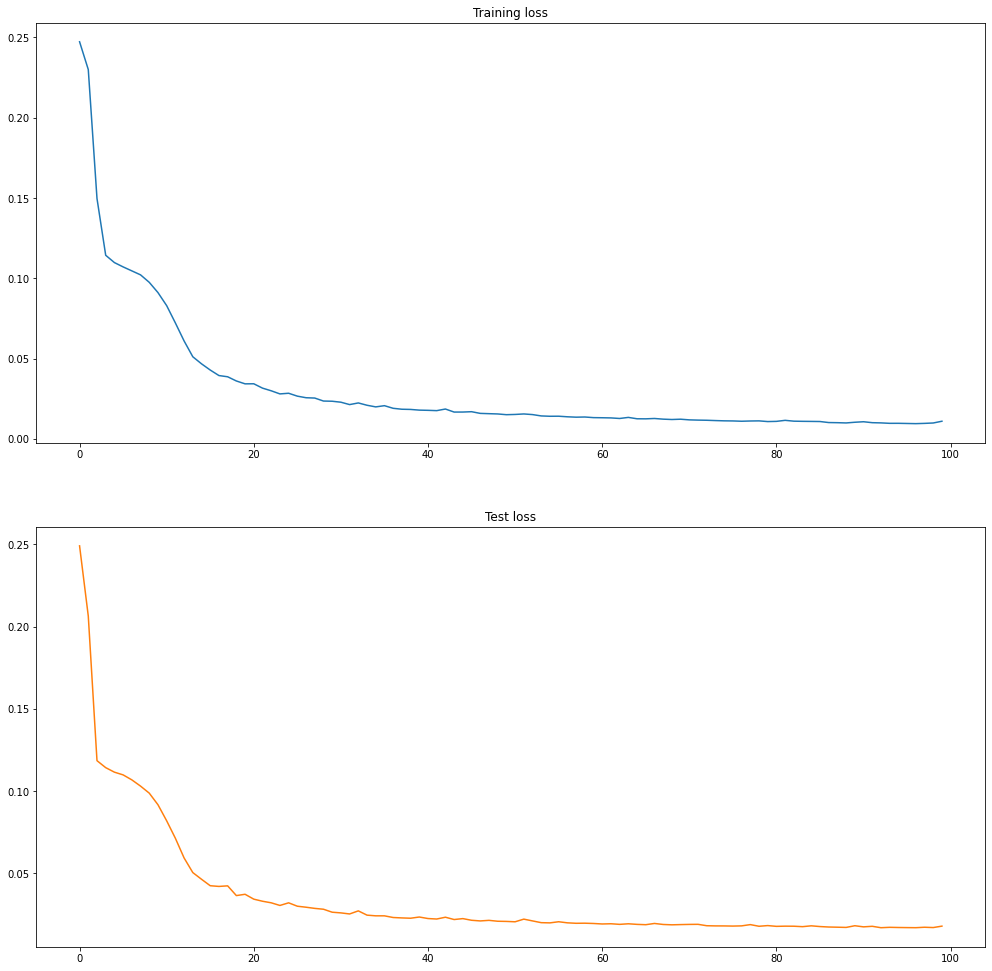

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(17,17))
axs[0].plot(epoch_vec, loss_train)
axs[0].set_title(f'Training loss')
axs[1].plot(epoch_vec, loss_test, 'tab:orange')
axs[1].set_title('Test loss')
plt.savefig(os.path.join(PATH, 'figures', '',filename+'.png'))